In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import visdom
#!tree   C:\Users\SiChen\Desktop\AndrewNg\ORL\orl_faces /A /f

In [2]:
def imshow(img,text,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()


In [3]:
#这个配置方式真的很不错。
class Config():
    training_dir = 'E:\ORL\orl_faces'
    testing_dir = 'E:\ORL\orl_faces'
    train_batch_size = 64
    train_number_epochs = 100

In [4]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        #http://blog.csdn.net/u013066730/article/details/59546677
        img0_tuple = random.choice(self.imageFolderDataset.imgs)  #看书本P141  dataset.imgs 输出的内容，就好理解了。是一个由元组构成的一维数组。
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [5]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)
folder_dataset.class_to_idx

{'s1': 0,
 's10': 1,
 's11': 2,
 's12': 3,
 's13': 4,
 's14': 5,
 's15': 6,
 's16': 7,
 's17': 8,
 's18': 9,
 's19': 10,
 's2': 11,
 's20': 12,
 's21': 13,
 's22': 14,
 's23': 15,
 's24': 16,
 's25': 17,
 's26': 18,
 's27': 19,
 's28': 20,
 's29': 21,
 's3': 22,
 's30': 23,
 's31': 24,
 's32': 25,
 's33': 26,
 's34': 27,
 's35': 28,
 's36': 29,
 's37': 30,
 's38': 31,
 's39': 32,
 's4': 33,
 's40': 34,
 's5': 35,
 's6': 36,
 's7': 37,
 's8': 38,
 's9': 39}

In [6]:
#可以对ImageFolder得到的数据集再进行一次处理，这是一个新的知识点。
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ]),
                                       should_invert=False)

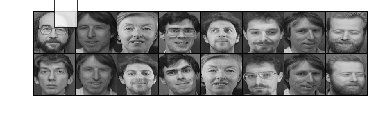

[[1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]


In [7]:
vis_dataloader = DataLoader(siamese_dataset,
                        num_workers=0,
                        batch_size=8,
                        shuffle=True,)#我认为是这样的，每次去Siamese_dataset中提取8组数据，在提取每一组的时候，
#都会调用一次其__getitem__()函数，总共调用8次。而每一次调用都很明显会调用__getitem__()里面的 img0_tuple = random.choice(self.imageFolderDataset.imgs)
#这里的random.choice()又是从folder_dataset中随机选择一张图片作为一组图片中的第一张图片。所以batch_size = 8中的8组图片的第一张可能是同一个人的。
#但是siamese_dataset与folder_dataset的元素的个数是相同的,我已经做过试验了，例如本程序的训练过程，训练集总共有400个图片，每个batch_size =64，所以我输出
#之后的结果为，一个epoch有7个batch，前6个batch有64组图片，最后一个batch有16组图片，总共还是400组。
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated), ' ')
print(example_batch[2].numpy())

In [8]:
vis_dataloader

In [9]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1= nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1,4,kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2)
        )

        self.fc1= nn.Sequential(
            nn.Linear(8*100*100,500),
            nn.ReLU(inplace=True),
            #nn.Dropout(p=0.5),

            nn.Linear(500,500),
            nn.ReLU(inplace= True),
            #nn.Dropout(0.5),

            nn.Linear(500,5)
        )
    def forward_once(self, x):
        output = self.cnn1(x)
        # print(output)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [10]:
class ContrastiveLoss(nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss,self).__init__()
        self.margin= margin

    def forward(self, output1, output2,label):
        #http://pytorch-cn.readthedocs.io/zh/latest/package_references/functional/#distance-functions
        euclidean_distance = F.pairwise_distance(output1, output2) 

        #http://blog.csdn.net/autocyz/article/details/53149760
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                  (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [11]:
train_dataloader = DataLoader(siamese_dataset,
                                  shuffle=True,
                                  num_workers=0,
                                  batch_size=Config.train_batch_size)

In [19]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

# counter for ------
counter = []
loss_history = []
iteration_number= 0
#net.state_dict().keys()
criterion
ContrastiveLoss?


In [27]:
vis = visdom.Visdom(env = u'test2')
for epoch in range(0, Config.train_number_epochs):
#for epoch in range(0, 3):
    for i, data in enumerate(train_dataloader,0):
        img0, img1, label= data
        #print(img0.size())
        img0, img1, label= Variable(img0).cuda(), Variable(img1).cuda(), Variable(label).cuda()
        output1, output2 = net(img0, img1)
        #print(output1.size())
        #print(output2.size())
        optimizer.zero_grad()
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
#        print(epoch,i,label.size())
        
#        if i % 10 == 0:
#            print("Epoch number {}\n Current loss {}\n".format(epoch, loss_contrastive.data[0]))
 #           iteration_number += 10
 #           counter.append(iteration_number)
 #           loss_history.append(loss_contrastive.data[0])
            
 #   vis.line(X = torch.Tensor([epoch]), Y = loss_contrastive.data.cpu(), win = 'face_recognition',opts= {'title': 'face_recognition','xlabel':'x','ylabel':'y'},update ='append' if epoch>0 else None)
#show_plot(counter, loss_history)

0 0 torch.Size([64, 1])
0 1 torch.Size([64, 1])
0 2 torch.Size([64, 1])
0 3 torch.Size([64, 1])
0 4 torch.Size([64, 1])
0 5 torch.Size([64, 1])
0 6 torch.Size([16, 1])
1 0 torch.Size([64, 1])
1 1 torch.Size([64, 1])
1 2 torch.Size([64, 1])
1 3 torch.Size([64, 1])
1 4 torch.Size([64, 1])
1 5 torch.Size([64, 1])
1 6 torch.Size([16, 1])
2 0 torch.Size([64, 1])
2 1 torch.Size([64, 1])
2 2 torch.Size([64, 1])
2 3 torch.Size([64, 1])
2 4 torch.Size([64, 1])
2 5 torch.Size([64, 1])
2 6 torch.Size([16, 1])
3 0 torch.Size([64, 1])
3 1 torch.Size([64, 1])
3 2 torch.Size([64, 1])
3 3 torch.Size([64, 1])
3 4 torch.Size([64, 1])
3 5 torch.Size([64, 1])
3 6 torch.Size([16, 1])
4 0 torch.Size([64, 1])
4 1 torch.Size([64, 1])
4 2 torch.Size([64, 1])
4 3 torch.Size([64, 1])
4 4 torch.Size([64, 1])
4 5 torch.Size([64, 1])
4 6 torch.Size([16, 1])
5 0 torch.Size([64, 1])
5 1 torch.Size([64, 1])
5 2 torch.Size([64, 1])
5 3 torch.Size([64, 1])
5 4 torch.Size([64, 1])
5 5 torch.Size([64, 1])
5 6 torch.Size([

KeyboardInterrupt: 

In [14]:
vis1 = visdom.Visdom(env = u'test3')
#vis2 = visdom.Visdom(env = u'test4')
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(100):
    x1,x2,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    vis1.line(X = torch.Tensor([i]),Y = euclidean_distance.cpu().data[0],win = 'face_recognition1',update ='append' if i>0 else None)
    vis1.images(concatenated, win = 'show'+ str(i), opts = {'title':str(i)+'-'+str(euclidean_distance.cpu().data)} )
    #print(euclidean_distance.cpu().data)
    
#    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.cpu().data.numpy()[0][0]))
